* In this notebook, we will implement the forward longitudinal vehicle model. 
* The model accepts throttle inputs and steps through the longitudinal dynamic equations. 
* Once implemented, we will be given a set of inputs that drives over a small road slope to test our model.

* The input to the model is a throttle percentage $x_\theta \in [0,1]$ which provides torque to the engine and subsequently accelerates the vehicle for forward motion. 

* The dynamic equations consist of many stages to convert throttle inputs to wheel speed (engine -> torque converter -> transmission -> wheel). These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

* Where $T_e$ is the engine torque, $GR$ is the gear ratio, $r_{eff}$ is the effective radius, $m$ is the vehicle mass, $x$ is the vehicle position, $F_x$ is the tire force, and $F_{load}$ is the total load force. 

* The engine torque is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

* The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ from an incline at angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear model.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}

* Note that the absolute value is ignored for friction since the model is used for only forward motion ($\dot{x} \ge 0$). 
 
* The tyre force is computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

* Where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 

* We setup the longitudinal model inside a Python class below. The vehicle begins with an initial velocity of 5 m/s and engine speed of 100 rad/s. All the relevant parameters are defined and like the bicycle model, a sampling time of 10ms is used for numerical integration.

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
 
        # ==================================
        #  Parameters
        # ==================================
    
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

* we implement the combined engine dynamic equations along with the force equations in the cell below. 
* The function `step` takes the throttle $x_\theta$ and incline angle $\alpha$ as inputs and performs numerical integration over one timestep to update the state variables. 
* Hint: Integrate to find the current position, velocity, and engine speed first, then propagate those values into the set of equations.

In [4]:
class Vehicle(Vehicle):
    def step(self, throttle, alpha):
        T_e = throttle * (self.a_0 + self.a_1 * self.w_e + self.a_2 * self.w_e**2)
        F_aero = self.c_a * self.v**2
        R_x = self.c_r1 * self.v
        F_g = self.m * self.g * np.sin(alpha)
        F_load = F_aero + R_x + F_g

        # torque equation (angular acceleration)
        self.w_e_dot = (T_e - self.GR * self.r_e * F_load) / self.J_e

        # tyre force
        w_w = self.GR * self.w_e
        s = (w_w * self.r_e - self.v) / self.v

        if abs(s) < 1:
            F_x = self.c * s
        else:
            F_x = self.F_max

        # acceleration
        self.a = (F_x - F_load) / self.m

        # update equations
        self.w_e += self.w_e_dot * self.sample_time 
        self.v += self.a * self.sample_time # v = at
        self.x += (self.v * self.sample_time) - (0.5 * self.a * self.sample_time**2) # x = vt-(1/2)at^2

* Using the model, we can send constant throttle inputs to the vehicle in the cell below.
* We will observe that the velocity converges to a fixed value based on the throttle input due to the aerodynamic drag and tire force limit. 
* A similar velocity profile can be seen by setting a negative incline angle $\alpha$. 
* In this case, gravity accelerates the vehicle to a terminal velocity where it is balanced by the drag force.

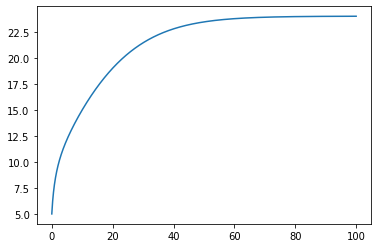

In [5]:
sample_time = 0.01
time_end = 100
model = Vehicle()

t_data = np.arange(0, time_end, sample_time)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 0.2

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.v
    model.step(throttle, alpha)

plt.plot(t_data, v_data)
plt.show()

* We will now drive the vehicle over a slope as shown in the diagram below.
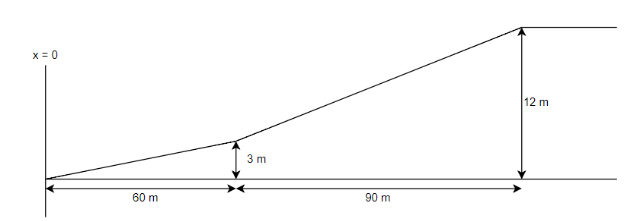
* to climb the slope, a trapezoidal throttle input is provided for the next 20 seconds as shown in the figure below.
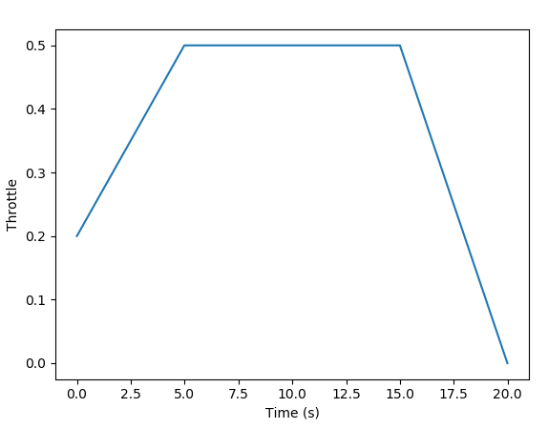
* The vehicle begins at 20% throttle and gradually increases to 50% throttle. This is maintained for 10 seconds as the vehicle climbs the steeper slope. Afterwards, the vehicle reduces the throttle to 0.

* In the cell below, implement the ramp angle profile $\alpha (x)$ and throttle profile $x_\theta (t)$ and step them through the vehicle dynamics. The vehicle position $x(t)$ is saved in the array $\textit{x_data}$. This will be used to grade your solution.


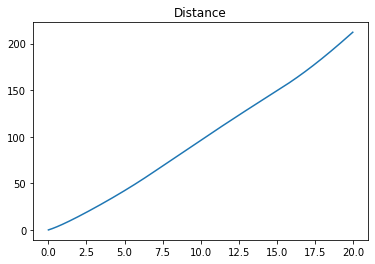

In [8]:
time_end = 20
t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_e_data = np.zeros_like(t_data)

# reset the states
model.reset()

# ==================================
#  Learner solution begins here
# ==================================
def angle(i, alpha, x):
    if x < 60:
        alpha[i] = np.arctan(3/60)
    elif x < 150:
        alpha[i] = np.arctan(9/90)
    else:
        alpha[i] = 0

throttle = np.zeros_like(t_data)
alpha = np.zeros_like(t_data)

#throttle depends on time and alpha depends on distance travelled (model.x)
for i in range(t_data.shape[0]):
    if t_data[i] < 5:
        throttle[i] = 0.2 + ((0.5 - 0.2)/5)*t_data[i]
        angle(i, alpha, model.x)
    elif t_data[i] < 15:
        throttle[i] = 0.5
        angle(i, alpha, model.x)
    else:
        throttle[i] = ((0 - 0.5)/(20 - 15))*(t_data[i] - 20)
        angle(i, alpha, model.x)
    
    #call the step function and update x_data array
    model.step(throttle[i], alpha[i])
    x_data[i] = model.x
    v_data[i] = model.v
    w_e_data[i] = model.w_e
     
# ==================================
#  Learner solution ends here
# ==================================

# Plot x vs t for visualization
plt.title('Distance')
plt.plot(t_data, x_data)
plt.show()

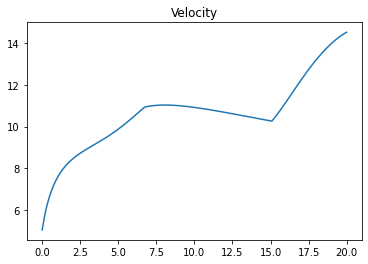

In [9]:
plt.title('Velocity')
plt.plot(t_data, v_data)
plt.show()

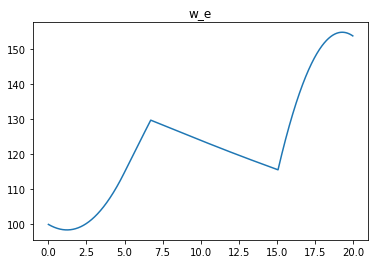

In [10]:
plt.title('w_e')
plt.plot(t_data, w_e_data)
plt.show()

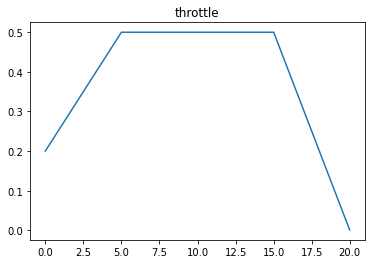

In [11]:
plt.title('throttle')
plt.plot(t_data, throttle)
plt.show()

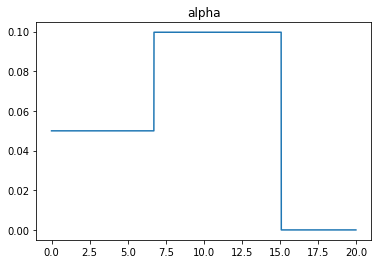

In [12]:
plt.title('alpha')
plt.plot(t_data, alpha)
plt.show()